In [50]:
import random
import math
import json
import os
from PIL import Image, ImageDraw
import seaborn as sns
from IPython.display import clear_output
from statistics import mode

from torch.utils.data import Dataset
import torchvision.transforms as transforms

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from xml.etree import ElementTree as et

import torch
import torchvision
from torchvision import ops
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import ssd300_vgg16
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split

import time
import argparse
from PIL import Image
from google.colab.patches import cv2_imshow
import skimage
from skimage import io
from PIL import Image
from urllib.request import urlopen

%matplotlib inline

print(torch.__version__)

2.0.1+cu118


In [51]:
%%bash
pip install numpy scipy scikit-image matplotlib

In [52]:
!pip install -U torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [53]:
!pip install tqdm
from tqdm import tqdm

In [54]:
class RandomShapesImageGenerator:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.mask = [[False] * width for _ in range(height)]
        self.boundary_boxes = []
        self.fig_type = []

    def generate_random_color(self):
        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)
        return red, green, blue

    def generate_non_overlapping_coords(self): # Генерация исходных координат по оси x, y
        for _ in range(150):
            x = random.randint(25, self.width - 25)
            y = random.randint(25, self.height - 25)

            # Проверка, находятся ли исходные координаты в пределах размеров изображения.
            if 0 <= int(x) < self.width and 0 <= int(y) < self.height:

                # Проверка, была ли эта точка в маске ранее занята (каким-либо другим элементом).
                if not any(self.mask[int(y)][int(x)] for i in range(int(x) - 25, int(x) + 26) for j in range(int(y) - 25, int(y) + 26)):
                    return x, y

    def check_mask_overlap(self, x, y, size, angle): # Проверка на пересечение фигур
        # Вычисление координаты пикселей, входящих в фигуру после вращения
        rotated_pixels = set()
        for i in range(y - size, y + size + 1):
            for j in range(x - size, x + size + 1):
                rotated_x, rotated_y = self.rotate_point((j, i), (x, y), -angle)  # Определение повернутых по оси координат
                if 0 <= rotated_x < self.width and 0 <= rotated_y < self.height:
                    rotated_pixels.add((int(rotated_x), int(rotated_y)))

        # Проверка маски только для пикселей, занимаемых фигурой после вращения
        for rotated_x, rotated_y in rotated_pixels:
            if self.mask[rotated_y][rotated_x]:
                return True
        return False

    def plot_image(self, image):
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def generate_image(self):
        image = Image.new("RGB", (self.width, self.height))
        draw = ImageDraw.Draw(image)
        background_color = self.generate_random_color() # Генерация цвета фона
        draw.rectangle([(0, 0), (self.width, self.height)], fill=background_color) # Создание изображения
        num_shapes = random.randint(1, 5)

        for _ in range(num_shapes):
            shape_type = random.choice(['rhombus', 'triangle', 'circle', 'hexagon'])
            self.fig_type.append(shape_type)
            color = self.generate_random_color()
            angle = random.uniform(0, 2 * math.pi)# Определение угла поворота фигуры
            x, y = self.generate_non_overlapping_coords() # Генерация исходных координат по оси x, y
            size = random.randint(25, min(self.width - x, self.height - y, x, y, 70)) # Определение размера фигуры
            while self.check_mask_overlap(x, y, size, angle): # Проверка на пересечение фигур
                x, y = self.generate_non_overlapping_coords()
                size = 25

            # Рисование фигуры и обработка маски с учетом угла
            if shape_type == 'rhombus':
                center_x = x
                center_y = y  # Это координаты центра ромба
                r1 = int(random.randint(0, 3)) # значение задающее изменчивость формы ромба
                points = [(x, y - size), (x + size/2 + r1, y), (x, y + size), (x - size/2 - r1, y)]
                rotated_points = [self.rotate_point(point, (center_x, center_y), angle) for point in points] # Вращение каждой точки относительно центра
                draw.polygon(rotated_points, fill=color, outline=color) # Рисуем ромб

                # Определение минимальной и максимальной координаты
                min_x = min(rotated_x for rotated_x, _ in rotated_points)
                max_x = max(rotated_x for rotated_x, _ in rotated_points)
                min_y = min(rotated_y for _, rotated_y in rotated_points)
                max_y = max(rotated_y for _, rotated_y in rotated_points)

                # Создание границы вокруг ромба
                self.boundary_boxes.append((min_x, min_y, max_x, max_y))
                self.draw_rotated_rhombus(draw, color, x, y, size, angle, r1)
                self.fill_mask(x, y, size)

            elif shape_type == 'triangle':
                # значения задающие изменчивость формы треугольника
                t1 = int(random.randint(0, 3))
                t2 = int(random.randint(0, 3))
                t3 = int(random.randint(0, 3))
                # Определение координаты вершин треугольника без учета вращения
                x1, y1 = x, y - size - t1
                x2, y2 = x + (size)/2 + t2, y
                x3, y3 = x - (size)/2 - t3, y

                # Вращение каждой вершины относительно центра
                center_x = x
                center_y = y
                rotated_x1, rotated_y1 = self.rotate_point((x1, y1), (center_x, center_y), angle)
                rotated_x2, rotated_y2 = self.rotate_point((x2, y2), (center_x, center_y), angle)
                rotated_x3, rotated_y3 = self.rotate_point((x3, y3), (center_x, center_y), angle)

                # Создание координат описывающего треугольника
                min_x = min(rotated_x1, rotated_x2, rotated_x3)
                max_x = max(rotated_x1, rotated_x2, rotated_x3)
                min_y = min(rotated_y1, rotated_y2, rotated_y3)
                max_y = max(rotated_y1, rotated_y2, rotated_y3)

                # Определяем границу для треугольника
                self.boundary_boxes.append((min_x, min_y, max_x, max_y))
                self.draw_rotated_triangle(draw, color, x, y, size, angle, t1, t2, t3)

                # Заполняем маску для текущего треугольника
                self.fill_mask(x, y, size)

            elif shape_type == 'circle':
                self.draw_circle(draw, color, x, y, size)
                self.fill_mask(x, y, size)
                self.boundary_boxes.append((x - size, y - size, x + size, y + size))

            elif shape_type == 'hexagon':
                # Определяем вершины гексагона без учета вращения
                center_x = x
                center_y = y
                points = []
                for i in range(6):
                    angle_offset = 2 * math.pi / 6 * i
                    px = size * math.cos(angle_offset + angle)
                    py = size * math.sin(angle_offset + angle)
                    points.append((px, py))

                # Переводим координаты обратно в систему координат изображения
                rotated_points = [(center_x + px, center_y + py) for px, py in points]

                # Определяем минимальные и максимальные значения координат
                min_x = min(rotated_x for rotated_x, _ in rotated_points)
                max_x = max(rotated_x for rotated_x, _ in rotated_points)
                min_y = min(rotated_y for _, rotated_y in rotated_points)
                max_y = max(rotated_y for _, rotated_y in rotated_points)

                # Определяем границу для текущего вращенного гексагона
                self.boundary_boxes.append((min_x, min_y, max_x, max_y))

                # Рисуем вращенный гексагон
                self.draw_hexagon(draw, color, x, y, size, angle)

                # Заполняем маску для текущего гексагона
                self.fill_mask(x, y, size)
        return image

    def draw_rotated_rhombus(self, draw, color, x, y, size, angle, t1):
        center_x = x
        center_y = y  # Координаты центра ромба
        points = [(x, y - size), (x + size/2 + t1, y), (x, y + size), (x - size/2 - t1, y)]

        # Вращаем каждую точку относительно центра
        rotated_points = [self.rotate_point(point, (center_x, center_y), angle) for point in points]

        # Рисуем ромб
        draw.polygon(rotated_points, fill=color, outline=color)

    def draw_rotated_triangle(self, draw, color, x, y, size, angle, t1, t2, t3):
        center_x = x
        center_y = y  # Координаты центра треугольника
        points = [(x, y - size - t1), (x + size/2 + t2, y), (x - size/2 - t3, y)]

        # Вращаем каждую точку относительно центра
        rotated_points = [self.rotate_point(point, (center_x, center_y), angle) for point in points]

        # Рисуем треугольник
        draw.polygon(rotated_points, fill=color, outline=color)

    def draw_circle(self, draw, color, x, y, radius):
        draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=color, outline=color)

    def draw_hexagon(self, draw, color, x, y, size, angle):
        center_x = x
        center_y = y
        points = []
        for i in range(6):
            angle_offset = 2 * math.pi / 6 * i
            pxx = size * math.cos(angle_offset + angle)
            py = size * math.sin(angle_offset + angle)
            points.append((pxx, py))

        # Переводим координаты обратно в систему координат изображения
        rotated_points = [(center_x + pxx, center_y + py) for pxx, py in points]

        draw.polygon(rotated_points, fill=color, outline=color)

    def draw_rotated_hexagon(self, draw, color, x, y, size, angle):
        center_x = x
        center_y = y  # Координаты центра гексагона
        points = []
        for i in range(6):
            angle_rad = angle * 15 * math.pi
            angle_offset = 2 * math.pi / 6 * i
            pxxx = x + size * math.cos(angle_offset + angle_rad)
            py = y + size * math.sin(angle_offset + angle_rad)
            points.append((pxxx, py))

        # Рисуем гексагон
        draw.polygon(points, fill=color, outline=color)

    def rotate_point(self, point, center, angle): # Функция отвечающая за вращение координат
        x, y = point
        cx, cy = center
        new_x = (x - cx) * math.cos(angle) - (y - cy) * math.sin(angle) + cx
        new_y = (x - cx) * math.sin(angle) + (y - cy) * math.cos(angle) + cy
        return new_x, new_y

    def fill_mask(self, x, y, size):
        for i in range(y - size, y + size + 1):
            for j in range(x - size, x + size + 1):
                if 0 <= i < self.height and 0 <= j < self.width:
                    self.mask[i][j] = True

    def round_to_tenth(self,value):# Функция для округления значений
        return round(value, 1)

    def generate_boundary_box_params(self, id_offset):
        params_list = []
        for idx, (bx1, by1, bx2, by2) in enumerate(self.boundary_boxes):
            bx1, by1, bx2, by2 = np.clip([bx1, by1, bx2, by2], 0, 256)
            # Округляем значения до десятой доли
            bx1, by1, bx2, by2 = int(bx1), int(by1), int(bx2), int(by2)
            wid = bx2 - bx1
            heig = by2 - by1
            bx1, by1, wid, heig = map(self.round_to_tenth, (bx1, by1, wid, heig))

            box_params = {
                "id": id_offset + idx + 1,
                "name": self.fig_type[idx],
                "region": {
                    "origin": {
                        "x": bx1,
                        "y": by1,
                    },
                    "size": {
                        "width": wid,
                        "height": heig
                    }
                }
            }
            params_list.append(box_params)
        return params_list

fig_folder = "fig1"
os.makedirs(fig_folder, exist_ok=True)


json_folder = "json1"
os.makedirs(json_folder, exist_ok=True)

id_counter = 0

for i in tqdm(range(3000)):

    # Создаем экземпляр класса
    generator = RandomShapesImageGenerator(256, 256)

    # Генерируем и сохраняем изображение
    image = generator.generate_image()
    image_path = os.path.join(fig_folder,  f"{i + 1:03d}.png")
    image.save(image_path)

    # Получаем параметры границ и сохраняем их в JSON
    boundary_params = generator.generate_boundary_box_params(id_counter)
    json_path = os.path.join(json_folder, f"{i + 1:03d}.json")
    with open(json_path, "w") as json_file:
        json.dump(boundary_params, json_file, indent=4)
    id_counter += len(generator.boundary_boxes)

100%|██████████| 3000/3000 [03:08<00:00, 15.96it/s]


In [55]:
import zipfile

def create_zip_archive(archive_name, source_folders):
    with zipfile.ZipFile(archive_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder in source_folders:
            for root, dirs, files in os.walk(folder):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, folder)
                    zipf.write(file_path, arcname)

# Указываем папки для архивирования
source_folders = ['fig1', 'json1']

# Создаем архив
create_zip_archive('data.zip', source_folders)

In [98]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, json_folder, transforms=None):
        self.image_folder = image_folder
        self.json_folder = json_folder
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])
        self.json_files = sorted([f for f in os.listdir(json_folder) if f.endswith(".json")])
        self.transforms = transforms
        self.class_labels = ['_','hexagon', 'triangle', 'circle', 'rhombus']

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        json_path = os.path.join(self.json_folder, self.json_files[idx])

        img = cv2.imread(image_path)# чтение файла
        image = img.astype(np.float32)

        with open(json_path, "r") as json_file:
            json_data = json.load(json_file)

        boxes = []
        labels = []

        # Обработка данных JSON для извлечения рамок и меток.
        for item in json_data:
            if item["name"] in self.class_labels:
                x, y, w, h = item["region"]['origin']["x"], item["region"]['origin']["y"], item["region"]['size']["width"], item["region"]['size']["height"]
                boxes.append([x, y, x + w, y + h])
                labels.append(self.class_labels.index(item["name"]))

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        if self.transforms:
            sample = self.transforms(image = image,
                                      bboxes = target['boxes'],
                                      labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

In [99]:
def plot_img_bbox(image, target, class_labels, aug):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(5, 5)

    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)

    ax.imshow(image)

    boxes = target['boxes']
    labels = target['labels']

    for box, label_idx in zip(boxes, labels):
        x1, y1, x2, y2 = box
        label = class_labels[label_idx]

        # Создайте описывающего прямоугольника
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Добавление названия фигуры
        ax.text(x1, y1, label, color='r', backgroundcolor='none', fontsize=12)
    if aug == True:
      ax.set_title("Augmented Image")
    else:
      ax.set_title("Original Image")

    plt.show()

In [100]:
def get_model(num_classes, modelName):

    # Загрузка модели
    if modelName == 'fasterrcnn':
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    if modelName == 'SSD_300':
        model = ssd300_vgg16(pretrained = True)
        from torchvision.models.detection.ssd import SSDClassificationHead
        anchors = model.anchor_generator.num_anchors_per_location()
        out_channels = [512, 1024, 512, 256, 256, 256]
        model.head.classification_head = SSDClassificationHead(out_channels, anchors, num_classes)
        return model


In [101]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [102]:
def get_transform(train):
    if train:
        return A.Compose([
            A.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [103]:
fig_folder = "fig1"
json_folder = "json1"

fig_files = sorted([f for f in os.listdir(fig_folder) if f.endswith(".png")])
print('fig_files',len(fig_files))


json_files = sorted([f for f in os.listdir(json_folder) if f.endswith(".json")])
print('json_files',len(json_files))
# Проверка количества файлов
assert len(fig_files) == len(json_files)

# Разделение на обучающую и тестовую выборки
test_size = 0.2  # Процент тестовой выборки
fig_train, fig_test, json_train, json_test = train_test_split(fig_files, json_files, test_size=test_size, random_state=42)

fig_files 3000
json_files 3000


In [104]:
# Исходные папки и папки назначения
source_fig_folder = "fig1"
source_json_folder = "json1"
dest_train_fig_folder = "train1/fig"
dest_train_json_folder = "train1/json"
dest_test_fig_folder = "test1/fig"
dest_test_json_folder = "test1/json"

# Создание папок назначения
os.makedirs(dest_train_fig_folder, exist_ok=True)
os.makedirs(dest_train_json_folder, exist_ok=True)
os.makedirs(dest_test_fig_folder, exist_ok=True)
os.makedirs(dest_test_json_folder, exist_ok=True)

# Перемещение файлов в папки назначения
for fig_file, json_file in zip(fig_files, json_files):
    if fig_file in fig_train:
        shutil.copy(os.path.join(source_fig_folder, fig_file), os.path.join(dest_train_fig_folder, fig_file))
        shutil.copy(os.path.join(source_json_folder, json_file), os.path.join(dest_train_json_folder, json_file))
    else:
        shutil.copy(os.path.join(source_fig_folder, fig_file), os.path.join(dest_test_fig_folder, fig_file))
        shutil.copy(os.path.join(source_json_folder, json_file), os.path.join(dest_test_json_folder, json_file))

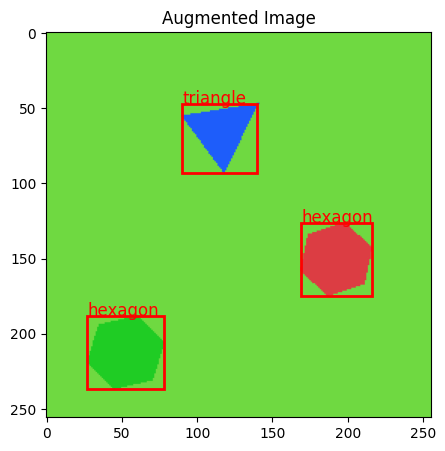

In [105]:
# Создание экземпляра CustomDataset
train = CustomDataset(image_folder= '/content/train1/fig',
                                json_folder= '/content/train1/json',
                                transforms = get_transform(train = True))

test= CustomDataset(image_folder= '/content/test1/fig',
                                json_folder= '/content/test1/json',
                                transforms = get_transform(train= False))

# Получение доступа к единичному примеру
sample = train[0]

image = sample[0]  # Доступ к картинке
target = sample[1]  # Доступ к target

# Визуализация картинки с описывающим прямоугольником
plot_img_bbox(image, target, train.class_labels, aug = True)

In [106]:
def form_loader(dataset,dataset_test ):
  train_data, val_data = train_test_split(dataset, test_size=0.1, random_state=101)

  train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = 5, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

  val_loader = torch.utils.data.DataLoader(
      val_data, batch_size = 5, shuffle=True, num_workers=2,
      collate_fn=collate_fn, drop_last = True)

  test_loader = torch.utils.data.DataLoader(
      dataset_test, batch_size=5, shuffle=False, num_workers=2,
      collate_fn=collate_fn, drop_last = True)

  return train_loader, val_loader, test_loader

In [107]:
train_loader_RCNN, val_loader_RCNN, test_loader_RCNN = form_loader(train, test)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/functional.py:487: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


In [108]:
n_batches, n_batches_test = len(train_loader_RCNN), len(val_loader_RCNN)

In [109]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 5
modelName = 'SSD_300'
model_RCNN = get_model(num_classes, modelName)
model_RCNN.to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_RCNN.parameters(), lr=learning_rate, weight_decay=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [110]:
def train_model(model, data_loader=None,val_loader=None, num_epoch=10):
    metric = MeanAveragePrecision()
    loss_accum_list = []
    map_list = []
    sum_image = 0

    # Словарь для подсчета количества натренированных фигур
    class_counts = {class_label: 0 for class_label in train.class_labels}

    for epoch in range(1, num_epoch + 1):
        print(f"Starting epoch {epoch} of {num_epoch}")
        time_start = time.time()
        loss_accum = 0.0
        model.train()

        for batch_idx, (images, targets) in enumerate(data_loader, 1):
            # Predict
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            loss_accum += loss.item()

            # Обновление словаря количества натренированных фигур
            for target in targets:
                labels = target["labels"]
                for label in labels:
                    class_counts[train.class_labels[label]] += 1

            sum_image += len(images)

        lr_scheduler.step()

        # Train losses
        train_loss = loss_accum / n_batches
        loss_accum_list.append(train_loss)

        elapsed = time.time() - time_start
        prefix = f"[Epoch {epoch:2d} / {num_epoch:2d}]"
        print(f"{prefix} Train loss: {train_loss:7.3f} [{elapsed:.0f} secs]", end=' | ')

        if epoch == 1:
            torch.save(model.state_dict(), "model_checkpoint2.pth")

        if epoch == num_epoch:
            torch.save(model.state_dict(), "model_checkpoint5.pth")

        preds_single = []
        targets_single = []

        for batch_idx, (images, targets) in enumerate(val_loader, 1):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            targets_single.extend(targets)

            model.eval()
            with torch.no_grad():
                pred = model(images)

            preds_single.extend(pred)

        metric.update(preds_single, targets_single)
        batch_map = metric.compute()
        map_list.append(batch_map['map'])
        print(f"Val mAP: {batch_map['map']}")

        clear_output(wait=True)
        plt.figure(figsize=(16,9))
        plt.grid(True)
        plt.plot(loss_accum_list, label='Train loss')
        plt.plot(map_list, label='map_list')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.suptitle('%d / %d - loss: %f , map: %f' % (num_epoch, epoch, loss_accum_list[-1], map_list[-1]))
        plt.show()

        print('sum_image', sum_image)
            # Вывод суммарного количества натренированных фигур
        for class_label, count in class_counts.items():
            print(f"{class_label}: {count} images")

    return model, loss_accum_list, map_list

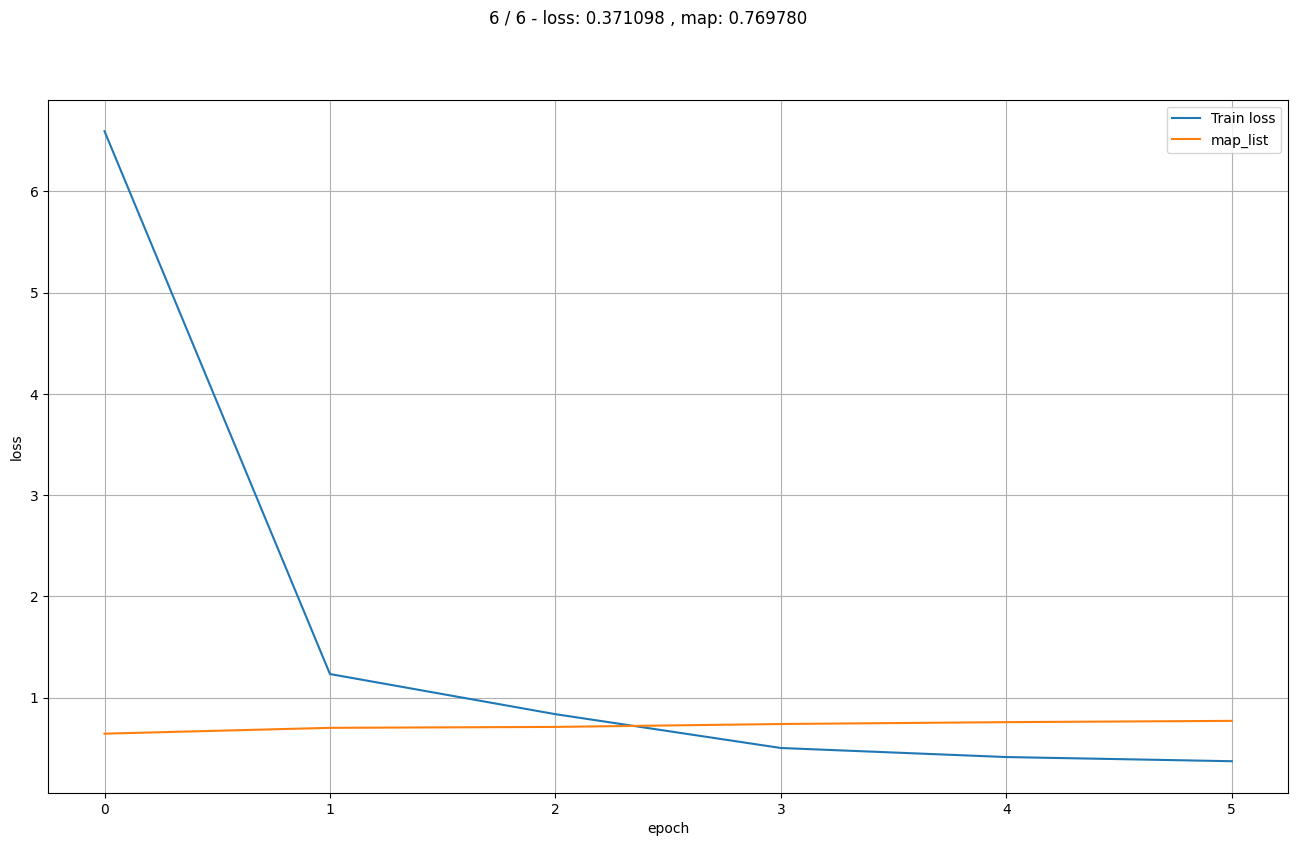

sum_image 13032
_: 0 images
hexagon: 9138 images
triangle: 9684 images
circle: 9678 images
rhombus: 9804 images


In [111]:
num_epoch = 6
model_RCNN, train_loss_RCNN, map_list_RCNN = train_model(model_RCNN, train_loader_RCNN, test_loader_RCNN, num_epoch)

In [112]:
def metric_test(model, test_loader):
    metric = MeanAveragePrecision()

    preds_single = []
    targets_single = []

    for batch_idx, (images, targets) in enumerate(test_loader, 1):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        targets_single.extend(targets)

        model.eval()
        with torch.no_grad():
            pred = model(images)

        preds_single.extend(pred)

    metric.update(preds_single, targets_single)
    test_map = metric.compute()

    print(f"Test mAP: {test_map['map']}")

In [138]:
checkpoint = torch.load("model_checkpoint5.pth")
model_RCNN.load_state_dict(checkpoint)
model5 =  model_RCNN

In [139]:
metric_test(model5, test_loader_RCNN)

Test mAP: 0.8275060653686523


### Предсказание IOU для одной картинки

In [140]:
def apply_threshold(prediction,threshold=0.15):
    index = prediction['scores'] > threshold
    pred = prediction.copy()
    pred['boxes'] = pred['boxes'][index]
    pred['scores'] = pred['scores'][index]
    pred['labels'] = pred['labels'][index]

    return pred

def apply_threshold_batch(prediction,threshold=0.15 ):
    preds = []

    for data in prediction:
        preds.append(apply_threshold(data, threshold))

    return preds

In [141]:
def plot_custom_img_bbox(image, prediction, target, class_labels):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(5, 5)

    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image.cpu()).convert('RGB')

    ax.imshow(image)

    # Отрисовка предсказанных ограничивающих рамок
    pred_boxes = prediction['boxes'].cpu().detach().numpy()
    pred_labels = prediction['labels'].cpu().detach().numpy()
    for box, label_idx in zip(pred_boxes, pred_labels):
        x1, y1, x2, y2 = box
        label = class_labels[label_idx.item()]  # Преобразуем тензор метки в скаляр
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none', label=f'Predicted {label}')
        ax.add_patch(rect)
        ax.text(x1, y1, label, color='r', backgroundcolor='none', fontsize=12)

    # Отрисовка действительных ограничивающих рамок (из целевых данных)
    true_boxes = target['boxes'].cpu().detach().numpy()
    true_labels = target['labels'].cpu().detach().numpy()
    for box, label_idx in zip(true_boxes, true_labels):
        x1, y1, x2, y2 = box
        label = class_labels[label_idx.item()]  # Преобразуем тензор метки в скаляр
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none', label=f'True {label}')
        ax.add_patch(rect)

    plt.show()

In [142]:
def calculate_iou(box1, box2):
    # box1 и box2 представлены в формате [x1, y1, x2, y2], где (x1, y1) - левый верхний угол, (x2, y2) - правый нижний угол
    # Площадь ограничивающей рамки box1
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])

    # Площадь ограничивающей рамки box2
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Находим координаты области пересечения
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Проверка на пересечение
    if x1 < x2 and y1 < y2:
        # Площадь области пересечения
        intersection_area = (x2 - x1) * (y2 - y1)
        # IoU
        iou = intersection_area / (area1 + area2 - intersection_area)
        return iou
    else:
        return 0.0

In [143]:
def iou_func(targets, filtered_preds, i):
    # Инициализируем список для хранения значений IoU
    iou_values = []

    # Перебираем все действительные ограничивающие рамки
    for true_box in targets[i]['boxes'].cpu().detach().numpy():
        max_iou = 0  # Инициализируем максимальное значение IoU для данной действительной рамки
        for pred_box in filtered_preds[i]['boxes'].cpu().detach().numpy():
            iou = calculate_iou(pred_box, true_box)
            max_iou = max(max_iou, iou)  # Обновляем максимальное значение IoU
        iou_values.append(max_iou)  # Добавляем максимальное значение IoU

    # Вычисляем среднее значение IoU только для ненулевых значений
    average_iou = sum(iou_values) / len(iou_values)
    return average_iou

In [144]:
def calculate_precision_recall(tp, fp, fn):
    precision = tp / (tp + fp + 1e-6)  # Добавлено 1e-6 для избежания деления на ноль
    recall = tp / (tp + fn + 1e-6)
    return precision, recall

In [145]:
def calculate_tp_fp_fn(model, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0
    total_objects = 0

    for i, (image, target) in enumerate(test_loader_RCNN, 1):
        # Преобразование изображения и целевой информации на устройство
        image = list(img.to(device) for img in image)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]

        # Получение предсказаний модели
        with torch.no_grad():
            pred = model(image)
            pred = apply_threshold_batch(pred, threshold=0.5)

        # Итерация по предсказаниям и целям
        for j, prediction in enumerate(pred):
            # Истинные ограничивающие рамки и метки
            true_boxes = target[j]['boxes'].cpu().detach().numpy()
            true_labels = target[j]['labels'].cpu().detach().numpy()

            # Предсказанные ограничивающие рамки, метки и оценки
            pred_boxes = prediction['boxes'].cpu().detach().numpy()
            pred_labels = prediction['labels'].cpu().detach().numpy()
            pred_scores = prediction['scores'].cpu().detach().numpy()

            # Создание массива булевых значений, где True, если IoU > порога
            iou_matrix = np.zeros((len(true_boxes), len(pred_boxes)), dtype=bool)
            for true_idx, true_box in enumerate(true_boxes):
                for pred_idx, pred_box in enumerate(pred_boxes):
                    iou = calculate_iou(true_box, pred_box)
                    iou_matrix[true_idx, pred_idx] = iou > iou_threshold

            # Вычисление TP и FP
            used_preds = set()  # Хранит индексы предсказаний, которые уже использованы как TP или FP
            for true_idx, true_label in enumerate(true_labels):
                for pred_idx, pred_label in enumerate(pred_labels):
                    if iou_matrix[true_idx, pred_idx] and true_label == pred_label and true_idx not in used_preds:
                        tp += 1
                        used_preds.add(true_idx)

                    elif iou_matrix[true_idx, pred_idx] and true_label != pred_label and true_idx not in used_preds:
                        fp += 1
                        used_preds.add(true_idx)

            total_objects += len(target[j]['labels'])
            # Вычисление FN
            fn = total_objects - fp- tp

    return tp, fp, fn

In [146]:
total_objects = 0

for images, targets in train_loader_RCNN:
    for target in targets:
        total_objects += len(target['labels'])

print(f"Общее количество объектов в тестовой выборке: {total_objects}")

Общее количество объектов в тестовой выборке: 6384


In [147]:
# Пример использования:
# Замените last_batch на фактический батч данных из вашего test_loader_RCNN.
tp, fp, fn = calculate_tp_fp_fn(model5, iou_threshold=0.75)

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Sum: {tp+fp+fn}")


True Positives (TP): 1862
False Positives (FP): 1
False Negatives (FN): 4
Sum: 1867


In [148]:
precision, recall = calculate_precision_recall(tp, fp, fn)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.9995
Recall: 0.9979


In [149]:
num_images = len(test_loader_RCNN.dataset)
print(f"Количество картинок в test_loader_RCNN: {num_images}")

Количество картинок в test_loader_RCNN: 613


In [150]:
def mmm(model):
    aver = []
    count = 0
    # Итерация по данным из test_loader_RCNN
    for i, (image, target) in enumerate(test_loader_RCNN, 1):
        # Преобразование изображения и целевой информации на устройство
        image = list(img.to(device) for img in image)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]
        # Получение предсказаний модели
        model.eval()
        with torch.no_grad():
            pred = model5(image)
            pred1 = apply_threshold_batch(pred, threshold=0.5)

        for j in range(5):
            # print('count', count)
            av = iou_func(target, pred1,j)
            aver.append(av)
            # plot_custom_img_bbox(image[j], pred1[j], target[j], train.class_labels)
            count += 1
    return aver

In [151]:
def iou_my(model, index):
    model.eval()
    image, target = test_loader_RCNN.dataset[index]
    pred = model([image.to(device)])
    iou_pred = apply_threshold_batch(pred, threshold=0.5)
    return image, iou_pred, target

In [152]:
aver = mmm(model5)
max_index = aver.index(max(aver))
min_index = aver.index(min(aver))
med_index = aver.index(mode(aver))

max_image, max_pred, max_target = iou_my(model5,max_index)
min_image, min_pred, min_target = iou_my(model5,min_index)
med_image, med_pred, med_target = iou_my(model5,med_index)

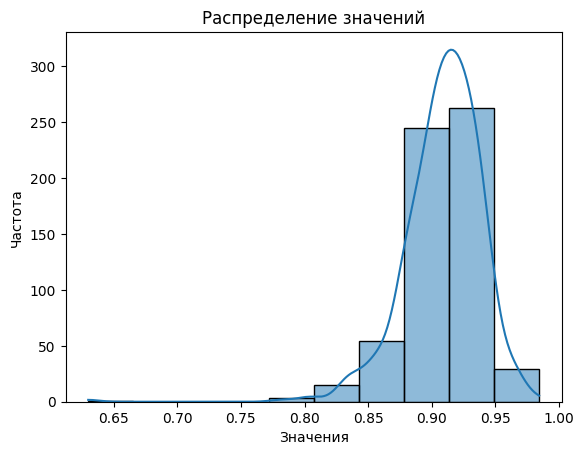

In [153]:
# Создайте распределение с помощью Seaborn
sns.histplot(aver, bins=10, kde=True)  # Вы можете настроить количество бинов (колонок) и отображение ядерной оценки плотности
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение значений')
plt.show()

IOU - наибольшего значения 0.9843464493751526


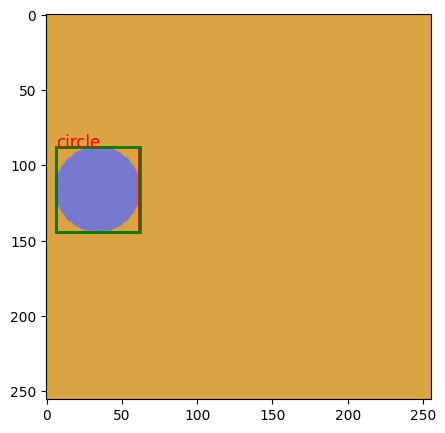

IOU - наименьшего значения 0.6299730936686198


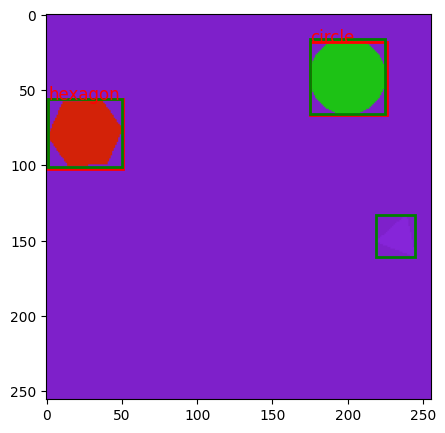

IOU - среднего значения 0.8951438069343567


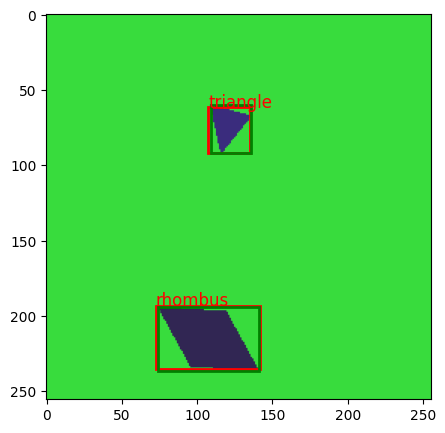

In [154]:
print('IOU - наибольшего значения', max(aver))
plot_custom_img_bbox(max_image, max_pred[0], max_target, train.class_labels)

print('IOU - наименьшего значения', min(aver))
plot_custom_img_bbox(min_image, min_pred[0], min_target, train.class_labels)

print('IOU - среднего значения', mode(aver))
plot_custom_img_bbox(med_image, med_pred[0], med_target, train.class_labels)

### Слабая модель

In [155]:
checkpoint = torch.load("model_checkpoint2.pth")
model_RCNN.load_state_dict(checkpoint)
model1 =  model_RCNN
metric_test(model1, test_loader_RCNN)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Test mAP: 0.6432888507843018


In [156]:
# Пример использования:
# Замените last_batch на фактический батч данных из вашего test_loader_RCNN.
tp, fp, fn = calculate_tp_fp_fn(model5, iou_threshold=0.65)

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Sum: {tp+fp+fn}")

True Positives (TP): 1768
False Positives (FP): 60
False Negatives (FN): 39
Sum: 1867


In [157]:
precision, recall = calculate_precision_recall(tp, fp, fn)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.9672
Recall: 0.9784


In [158]:
aver = mmm(model1)
max_index = aver.index(max(aver))
min_index = aver.index(min(aver))
med_index = aver.index(mode(aver))

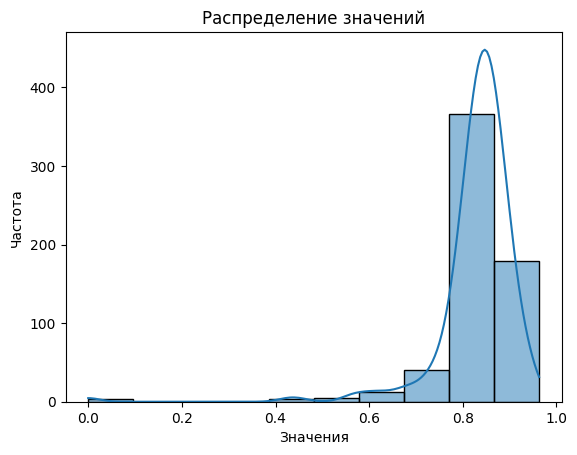

In [159]:
# Создайте распределение с помощью Seaborn
sns.histplot(aver, bins=10, kde=True)  # Вы можете настроить количество бинов (колонок) и отображение ядерной оценки плотности
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение значений')
plt.show()

In [160]:
max_image, max_pred, max_target = iou_my(model1,max_index)
min_image, min_pred, min_target = iou_my(model1,min_index)
med_image, med_pred, med_target = iou_my(model1,med_index)

IOU - наибольшего значения 0.9628891944885254


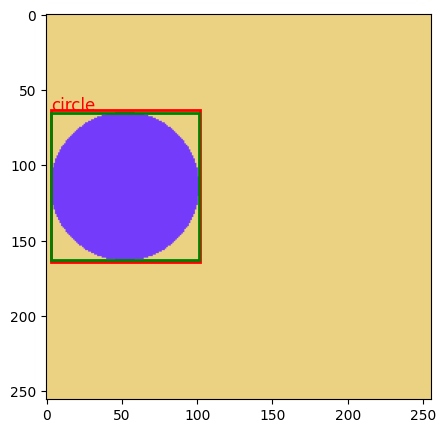

IOU - наименьшего значения 0.0


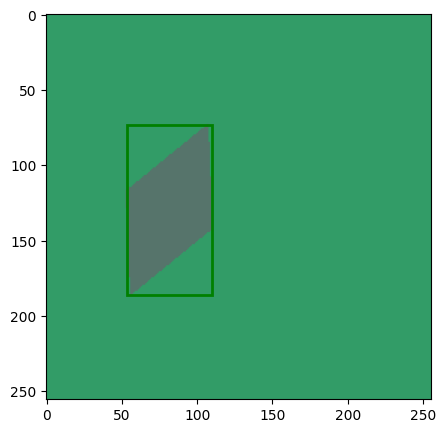

IOU - среднего значения 0.0


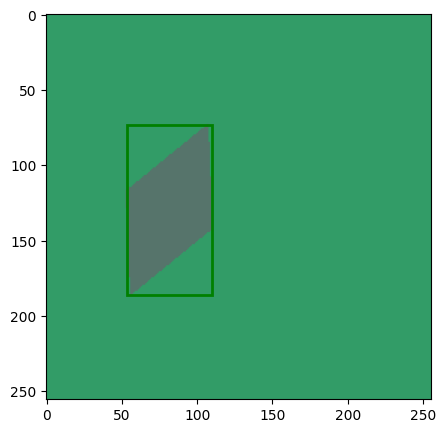

In [161]:
print('IOU - наибольшего значения', max(aver))
plot_custom_img_bbox(max_image, max_pred[0], max_target, train.class_labels)

print('IOU - наименьшего значения', min(aver))
plot_custom_img_bbox(min_image, min_pred[0], min_target, train.class_labels)

print('IOU - среднего значения', mode(aver))
plot_custom_img_bbox(med_image, med_pred[0], med_target, train.class_labels)